# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [61]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, sum, split, udf, isnan, when, count, countDistinct
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [5]:
#check installed spark version
print('Version: ', spark.version)

Version:  2.4.3


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
file = "mini_sparkify_event_data.json"
df = spark.read.json(file)

#reducing memory
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [103]:
#a glance of the data
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [104]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [105]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [106]:
#count null value from each column
for column in df.columns:
    print(column, "missing values:", df.filter(F.isnull(df[column])).count())

artist missing values: 58392
auth missing values: 0
firstName missing values: 8346
gender missing values: 8346
itemInSession missing values: 0
lastName missing values: 8346
length missing values: 58392
level missing values: 0
location missing values: 8346
method missing values: 0
page missing values: 0
registration missing values: 8346
sessionId missing values: 0
song missing values: 58392
status missing values: 0
ts missing values: 0
userAgent missing values: 8346
userId missing values: 0


Check for missing values in string form since from the lecture, it is mentioned that the missing values are in the form of string

In [107]:
#checking missing values in the form of string ("")
for column in df.columns:
    print(column, "missing values (str):", df.filter(df[column] == '').count())

artist missing values (str): 0
auth missing values (str): 0
firstName missing values (str): 0
gender missing values (str): 0
itemInSession missing values (str): 0
lastName missing values (str): 0
length missing values (str): 0
level missing values (str): 0
location missing values (str): 0
method missing values (str): 0
page missing values (str): 0
registration missing values (str): 0
sessionId missing values (str): 0
song missing values (str): 0
status missing values (str): 0
ts missing values (str): 0
userAgent missing values (str): 0
userId missing values (str): 8346


From above, we see that there are some missing values for userID in string form. UserID and sessionID are the primary data points that we will use, thus it is important for it to be filled.

In [7]:
df_clean = df.dropna(how='any', subset=['userId', 'sessionId'])

In [8]:
df_clean = df_clean.filter(df_clean.userId != '')

In [110]:
# check if there's still missing values of userID
print('userId empty string values:', df_clean.filter(df_clean.userId == '').count())

userId empty string values: 0


In [9]:
# clean data points
df_clean.count()

278154

In [112]:
df_clean.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [113]:
df_clean.describe('sessionID').show()

+-------+------------------+
|summary|         sessionID|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [114]:
# checking the date time
df_clean.select("ts","registration").show()

+-------------+-------------+
|           ts| registration|
+-------------+-------------+
|1538352117000|1538173362000|
|1538352180000|1538331630000|
|1538352394000|1538173362000|
|1538352416000|1538331630000|
|1538352676000|1538173362000|
|1538352678000|1538331630000|
|1538352886000|1538331630000|
|1538352899000|1538173362000|
|1538352905000|1538173362000|
|1538353084000|1538173362000|
|1538353146000|1538331630000|
|1538353150000|1538331630000|
|1538353218000|1538173362000|
|1538353375000|1538331630000|
|1538353376000|1538331630000|
|1538353441000|1538173362000|
|1538353576000|1538331630000|
|1538353668000|1537365219000|
|1538353687000|1538173362000|
|1538353744000|1538331630000|
+-------------+-------------+
only showing top 20 rows



In [25]:
# Change ts and registration timestamp format to DateType format
df_clean = df_clean.withColumn('ts', F.from_unixtime(F.col('ts') / 1000))

In [26]:
df_clean = df_clean.withColumn('registration', F.from_unixtime(F.col('registration') / 1000))

In [27]:
df_clean.select("ts","registration").show()

+-------------------+-------------------+
|                 ts|       registration|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-09-28 22:22:42|
|2018-10-01 00:03:00|2018-09-30 18:20:30|
|2018-10-01 00:06:34|2018-09-28 22:22:42|
|2018-10-01 00:06:56|2018-09-30 18:20:30|
|2018-10-01 00:11:16|2018-09-28 22:22:42|
|2018-10-01 00:11:18|2018-09-30 18:20:30|
|2018-10-01 00:14:46|2018-09-30 18:20:30|
|2018-10-01 00:14:59|2018-09-28 22:22:42|
|2018-10-01 00:15:05|2018-09-28 22:22:42|
|2018-10-01 00:18:04|2018-09-28 22:22:42|
|2018-10-01 00:19:06|2018-09-30 18:20:30|
|2018-10-01 00:19:10|2018-09-30 18:20:30|
|2018-10-01 00:20:18|2018-09-28 22:22:42|
|2018-10-01 00:22:55|2018-09-30 18:20:30|
|2018-10-01 00:22:56|2018-09-30 18:20:30|
|2018-10-01 00:24:01|2018-09-28 22:22:42|
|2018-10-01 00:26:16|2018-09-30 18:20:30|
|2018-10-01 00:27:48|2018-09-19 13:53:39|
|2018-10-01 00:28:07|2018-09-28 22:22:42|
|2018-10-01 00:29:04|2018-09-30 18:20:30|
+-------------------+-------------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
df_clean.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+---------+--------------------+------+-------------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|       registration|sessionId|                song|status|                 ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+---------+--------------------+------+-------------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|2018-09-28 22:22:42|       29|           Rockpools|   200|2018-10-01 00:01:57|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|  

In [19]:
#using sparksql for EDA
#Create a temporary view to perform SQL operations
user_log = spark.read.json("mini_sparkify_event_data.json")

user_log.createOrReplaceTempView("sparkify")


In [ ]:
#sqlContext.setConf("spark.sql.tungsten.enabled", "false")

#### Pre-eliminary analysis of users as well as cancellation confirmation and downgrade as the indicator of churning

In [20]:
# explore by page
spark.sql('''
        SELECT 
        page,
        COUNT((userID)) AS count_user
        FROM sparkify
        GROUP BY page
        ORDER BY 2 DESC
''').show()

+--------------------+----------+
|                page|count_user|
+--------------------+----------+
|            NextSong|    228108|
|                Home|     14457|
|           Thumbs Up|     12551|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|         Roll Advert|      3933|
|               Login|      3241|
|              Logout|      3226|
|         Thumbs Down|      2546|
|           Downgrade|      2055|
|                Help|      1726|
|            Settings|      1514|
|               About|       924|
|             Upgrade|       499|
|       Save Settings|       310|
|               Error|       258|
|      Submit Upgrade|       159|
|    Submit Downgrade|        63|
|              Cancel|        52|
|Cancellation Conf...|        52|
+--------------------+----------+
only showing top 20 rows



In [21]:
# unique number of users 
spark.sql('''
        SELECT 
        COUNT(DISTINCT(userID))
        FROM sparkify
''').show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   226|
+----------------------+



In [22]:
# number of users who has "Cancellation Confirmation"
spark.sql('''
    SELECT
    COUNT (DISTINCT userID)
    FROM sparkify
    WHERE page = 'Cancellation Confirmation'
''').show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



In [23]:
# number of users who has "Downgrade"
spark.sql('''
    SELECT
    COUNT (DISTINCT userID)
    FROM sparkify
    WHERE page = 'Downgrade'
''').show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   154|
+----------------------+



#### Gender Distribution

In [24]:
gender = spark.sql('''
    SELECT
    COUNT (DISTINCT userID) AS count_user,
    gender
    FROM sparkify
    GROUP BY gender
''').show()

+----------+------+
|count_user|gender|
+----------+------+
|       104|     F|
|         1|  null|
|       121|     M|
+----------+------+



#### Level Distribution (Paid or Not)

In [25]:
spark.sql('''
    SELECT
    userID,
    level
    FROM sparkify
    --GROUP BY level
''').show()

+------+-----+
|userID|level|
+------+-----+
|    30| paid|
|     9| free|
|    30| paid|
|     9| free|
|    30| paid|
|     9| free|
|     9| free|
|    30| paid|
|    30| paid|
|    30| paid|
|     9| free|
|     9| free|
|    30| paid|
|     9| free|
|     9| free|
|    30| paid|
|     9| free|
|    74| free|
|    30| paid|
|     9| free|
+------+-----+
only showing top 20 rows



From the above, we can assume that there are 136 users who changed from free to paid

#### Most popular songs played

In [26]:
spark.sql('''
    SELECT
    COUNT(song),
    song
    FROM sparkify
    GROUP BY song
    ORDER BY 1 DESC
''').show(n = 10)

+-----------+--------------------+
|count(song)|                song|
+-----------+--------------------+
|       1153|      You're The One|
|       1026|                Undo|
|        854|             Revelry|
|        728|       Sehr kosmisch|
|        641|Horn Concerto No....|
|        574|Dog Days Are Over...|
|        466|             Secrets|
|        459|        Use Somebody|
|        435|              Canada|
|        424|             Invalid|
+-----------+--------------------+
only showing top 10 rows



#### Most popular artist listened by users

In [27]:
spark.sql('''
    SELECT
    artist,
    COUNT (artist)
    FROM sparkify
    GROUP BY artist
    ORDER BY 2 DESC
''').show(n = 10)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
|      The Black Keys|         1125|
|                Muse|         1090|
|       Justin Bieber|         1044|
|        Jack Johnson|         1007|
|              Eminem|          953|
+--------------------+-------------+
only showing top 10 rows



#### Item in session

In [28]:
spark.sql('''
    SELECT
    userId,
    sessionId,
    (itemInSession)
    FROM sparkify

''').show(n = 10)

+------+---------+-------------+
|userId|sessionId|itemInSession|
+------+---------+-------------+
|    30|       29|           50|
|     9|        8|           79|
|    30|       29|           51|
|     9|        8|           80|
|    30|       29|           52|
|     9|        8|           81|
|     9|        8|           82|
|    30|       29|           53|
|    30|       29|           54|
|    30|       29|           55|
+------+---------+-------------+
only showing top 10 rows



#### Length of Song

In [29]:
spark.sql('''
    SELECT
    userId,
    sessionId,
    length,
    song,
    page
    FROM sparkify
''').show(n = 10)

+------+---------+---------+--------------------+---------------+
|userId|sessionId|   length|                song|           page|
+------+---------+---------+--------------------+---------------+
|    30|       29|277.89016|           Rockpools|       NextSong|
|     9|        8|236.09424|              Canada|       NextSong|
|    30|       29| 282.8273|   Time For Miracles|       NextSong|
|     9|        8|262.71302|Knocking On Forbi...|       NextSong|
|    30|       29|223.60771|Harder Better Fas...|       NextSong|
|     9|        8|208.29995|      Don't Leave Me|       NextSong|
|     9|        8|260.46649|         Run Run Run|       NextSong|
|    30|       29|185.44281|Passengers (Old A...|       NextSong|
|    30|       29|     null|                null|Add to Playlist|
|    30|       29|134.47791|          Fuck Kitty|       NextSong|
+------+---------+---------+--------------------+---------------+
only showing top 10 rows



#### The definition of churn that I am going to use in this project is the one who has Cancellation Confirmation as it is more like a definite indicator

In [28]:
# create a churn column, classify it from the cancellation confirmation 
churn = F.udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0, IntegerType())

In [29]:
df_churn = df_clean.withColumn('churn_user', churn(df_clean.page))

In [30]:
df_churn = df_churn.groupBy('userId').agg(F.sum('churn_user').alias('churn_group'))

In [31]:
df_churn.show()

+------+-----------+
|userId|churn_group|
+------+-----------+
|100010|          0|
|200002|          0|
|   125|          1|
|    51|          1|
|   124|          0|
|     7|          0|
|    54|          1|
|    15|          0|
|   155|          0|
|   132|          0|
|   154|          0|
|100014|          1|
|   101|          1|
|    11|          0|
|   138|          0|
|300017|          0|
|    29|          1|
|    69|          0|
|100021|          1|
|    42|          0|
+------+-----------+
only showing top 20 rows



In [32]:
# joining the churn column to the original column
df_clean = df_clean.join(df_churn, ['userId'])
df_clean.show(n = 5)

+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------------+---------+--------------------+------+-------------------+--------------------+-----------+-----------+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page|       registration|sessionId|                song|status|                 ts|           userAgent|churn_group|churn_group|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------------+---------+--------------------+------+-------------------+--------------------+-----------+-----------+
|100010|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|2018-09-27 02:45:40|       31|Captain Tyin Knot...|   200|2018-10-08 12:58:54|"Mozilla/5.0 (

In [123]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_group: long (nullable = true)



In [36]:
# plot how many users who curn and not
classify_churn = df_clean.select("userId", "churn_group").distinct().groupBy("churn_group").count().toPandas()
classify_churn['churn_group'] = ["no", "yes"]
classify_churn

,churn_group,count
0,no,173
1,yes,52


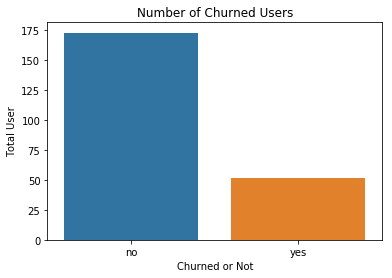

In [37]:
sns.barplot(x ="churn_group", y = "count", data = classify_churn)
plt.title('Number of Churned Users')
plt.xlabel('Churned or Not')
plt.ylabel('Total User')
plt.show()

### Exploratory Data Analysis for Churned and Not Churned

#### Gender and Churned

In [38]:
gender_churn = df_clean.select("userId", "gender", "churn_group").distinct().groupBy("churn_group", "gender").count().toPandas()
gender_churn

,churn_group,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


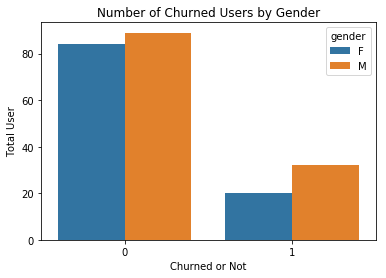

In [39]:
# plot the comparison of male and female who churned
sns.barplot(x='churn_group', y='count', hue = 'gender', data = gender_churn)
plt.title('Number of Churned Users by Gender')
plt.xlabel('Churned or Not')
plt.ylabel('Total User')
plt.show()

From the graph above, more male is both churned and not churned compared to female. 
In males, churn rate is 0.26 which is 0.19 in females

#### Paid or Not and Churned

In [40]:
level_churn = df_clean.dropDuplicates(["userId"]).groupby(["churn_group", "level"]).count().toPandas()
level_churn

,churn_group,level,count
0,1,paid,8
1,1,free,44
2,0,free,133
3,0,paid,40


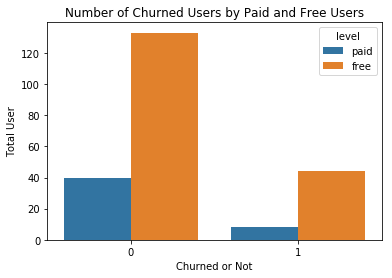

In [41]:
# plot the comparison of paid and free users who churned
sns.barplot(x='churn_group', y='count', hue = 'level', data = level_churn)
plt.title('Number of Churned Users by Paid and Free Users')
plt.xlabel('Churned or Not')
plt.ylabel('Total User')
plt.show()

The ratio of paid users who churn is 0.17 while for free users it is 0.25. From the graph above, the ration of free users are higher both in churn and not churned.

#### Overview of the event on the page column

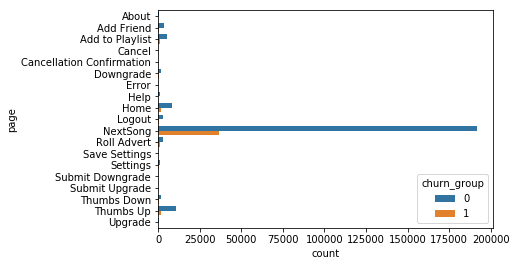

In [42]:
df_page = df_clean.select(["page","churn_group"]).groupby([ "page","churn_group"]).count().sort("page").toPandas()
sns.barplot( x="count",y="page", hue="churn_group", data=df_page)

#### Number of Songs played - Churned and Not Churned Users

In [43]:
# number of songs played is indicated when user is clicking nextsong page
# below is the total number of songs played (not with distinct users) since dropping duplicates users will reduce a lot of songs as well that the user play
song_churn = df_clean.where(df_clean['page'] == 'NextSong').groupby(["churn_group"]).count().toPandas()
song_churn

,churn_group,count
0,0,191714
1,1,36394


In [44]:
song_avg = df_clean.where(df_clean['page'] == 'NextSong').groupby("churn_group").agg((F.count("churn_group")/F.countDistinct("userId")).alias('avgsong')).toPandas()
song_avg

,churn_group,avgsong
0,0,1108.173410
1,1,699.884615


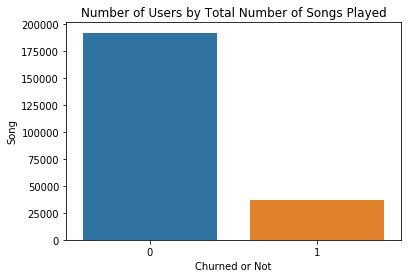

In [45]:
# plot the comparison of churned users and not by the next song page
sns.barplot(x='churn_group', y='count', data = song_churn)
plt.title('Number of Users by Total Number of Songs Played')
plt.xlabel('Churned or Not')
plt.ylabel('Song')
plt.show()

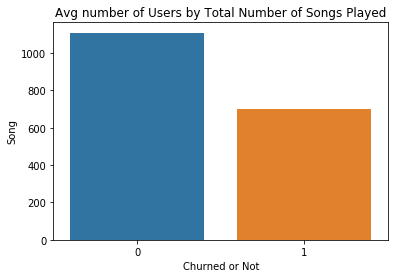

In [46]:
# plot the comparison of churned users and not by the next song page
sns.barplot(x='churn_group', y='avgsong', data = song_avg)
plt.title('Avg number of Users by Total Number of Songs Played')
plt.xlabel('Churned or Not')
plt.ylabel('Song')
plt.show()

From the graph above, churned users have played way less songs than the non-churned one.

#### Average Number of Songs Played per Day for Churned and Non-Churned Users

In [47]:
# filter to the next song action page only
# convert timestamp(ts) to day format
song_day =  df_clean.where('page == "NextSong"').withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of page per day group by user id and the day 
song_day = song_day.groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('numSong'))
# group by again by users and get the avg of num of page next song per day for the user
song_day = song_day. groupBy('userId').agg(F.avg(F.col('numSong')).alias('AvgNumSongPerDay'))
# join the table with the df churn table and convert to Pandas
pd_songday_churned = song_day.join(df_churn, ['userId']).toPandas()

In [48]:
pd_songday_churned.head()

,userId,AvgNumSongPerDay,churn_group
0,200002,55.285714,0
1,100010,39.285714,0
2,125,8.000000,1
3,124,127.468750,0
4,51,162.384615,1


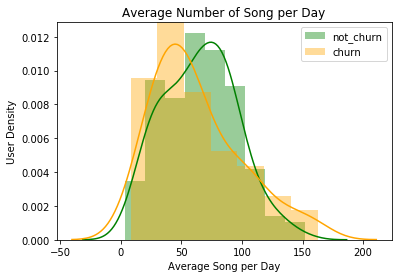

In [49]:
# Sort the dataframe based on churn and not churn
avgsong_nochurn = pd_songday_churned.loc[pd_songday_churned['churn_group'] == 0]
avgsong_churn = pd_songday_churned.loc[pd_songday_churned['churn_group'] == 1]

# plot the distribution of churn and not churn users
sns.distplot(avgsong_nochurn[['AvgNumSongPerDay']], label = 'not_churn', color = 'green')
sns.distplot(avgsong_churn[['AvgNumSongPerDay']], label = 'churn', color = 'orange')
plt.title('Average Number of Song per Day')
plt.xlabel('Average Song per Day')
plt.ylabel('User Density')

plt.legend()
plt.show()

#### Number of Songs Played per Hour

In [50]:
# filter to the next song action page only
# convert timestamp(ts) to hour format
song_hour =  df_clean.where('page == "NextSong"').withColumn('hour_ts', F.date_trunc('hour', F.col('ts')))
# aggregate the number of page per day group by user id and the day 
song_hour = song_hour.select(['song', 'hour_ts']).groupBy(['hour_ts']).agg(F.count(F.col('song')).alias('song')).orderBy('hour_ts').alias('countSong').toPandas()

In [51]:
song_hour.head()

,hour_ts,song
0,2018-10-01 00:00:00,45
1,2018-10-01 01:00:00,52
2,2018-10-01 02:00:00,51
3,2018-10-01 03:00:00,21
4,2018-10-01 04:00:00,40


#### Length of Song per Day for Churned and Non-Churned Users

In [52]:
# filter to the next song action page only
# convert timestamp(ts) to day format
# length is defined for length of song (in second) played since it occurs only at page nextsong
length_song_day =  df_clean.withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of length per day group by user id and the day 
length_song_day = length_song_day.groupBy(['userId', 'ts']).agg(F.sum(F.col('length')).alias('lengthSongPerDay'))
# group by again by users and get the avg of num of length song per day for the user
length_song_day = length_song_day.groupBy('userId').agg(F.avg(F.col('lengthSongPerDay')).alias('AvgLengthSongPerDay'))
# join the table with the df churn table and convert to Pandas
pd_lengthsongday_churned = length_song_day.join(df_churn, ['userId']).toPandas()

In [53]:
pd_lengthsongday_churned.head()

,userId,AvgLengthSongPerDay,churn_group
0,200002,13429.839420,0
1,100010,9562.985336,0
2,125,2089.113100,1
3,124,31634.752900,0
4,51,40251.987908,1


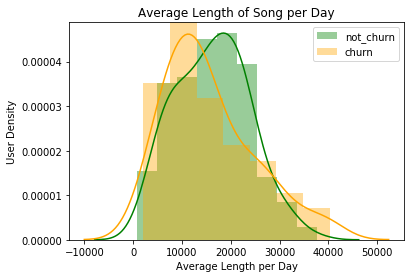

In [54]:
# Sort the dataframe based on churn and not churn
avglength_song_nochurn = pd_lengthsongday_churned.loc[pd_lengthsongday_churned['churn_group'] == 0]
avglength_song_churn = pd_lengthsongday_churned.loc[pd_lengthsongday_churned['churn_group'] == 1]

# plot the distribution of churn and not churn users
sns.distplot(avglength_song_nochurn[['AvgLengthSongPerDay']], label = 'not_churn', color = 'green')
sns.distplot(avglength_song_churn[['AvgLengthSongPerDay']], label = 'churn', color = 'orange')
plt.title('Average Length of Song per Day')
plt.xlabel('Average Length per Day')
plt.ylabel('User Density')

plt.legend()
plt.show()

#### Number of Item in Sessions for Churned and Non-Churned Users

In [55]:
# user id and session id is not unique, we use max value for iteminsession, since it increases incrementally in 1 session id
item_churned =  df_clean.select('userId', 'sessionId', 'ItemInSession').groupBy('userId', 'sessionId').agg(F.max(F.col('itemInSession')).alias('totalItem'))
item_churned.show()

+------+---------+---------+
|userId|sessionId|totalItem|
+------+---------+---------+
|    92|      358|       72|
|    42|      433|       22|
|   101|      635|      889|
|   120|      627|      264|
|   140|      798|        5|
|   122|      691|        8|
|    29|     1030|       18|
|     8|     1200|       21|
|    96|     1653|      165|
|   153|     1794|       75|
|    97|     2019|       85|
|    35|     2270|       12|
|   110|     1776|       23|
|300011|       60|       39|
|   137|      136|        6|
|    40|      484|       83|
|    35|      544|       15|
|    24|      620|        9|
|    47|       46|        2|
|    85|     1098|       88|
+------+---------+---------+
only showing top 20 rows



In [56]:
item_churned = item_churned.groupBy('userId').agg(F.avg(F.col('totalItem')).alias('avgItemInSession'))
item_churned.show()

+------+------------------+
|userId|  avgItemInSession|
+------+------------------+
|100010| 54.42857142857143|
|200002|              80.0|
|   125|              10.0|
|    51|             251.9|
|   124|170.13793103448276|
|     7|28.428571428571427|
|    54| 94.21621621621621|
|    15|154.86666666666667|
|   155|171.66666666666666|
|100014|51.833333333333336|
|   132|          147.9375|
|   154|41.333333333333336|
|   101|             219.7|
|    11|              54.0|
|300017| 70.76190476190476|
|   138|166.93333333333334|
|    29| 107.8529411764706|
|    69|150.88888888888889|
|100021|              66.4|
|    42| 91.70212765957447|
+------+------------------+
only showing top 20 rows



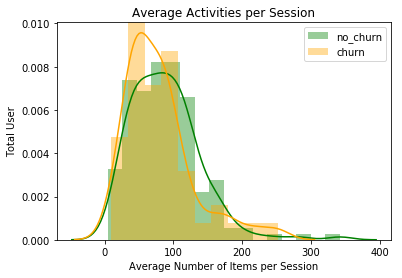

In [57]:
# join the item per session table with the churn df and convert to Pandas
pd_item_churned = item_churned.join(df_churn, ['userId']).toPandas()

# Sort the dataframe based on churn and not churn
itemsess_nochurn = pd_item_churned.loc[pd_item_churned['churn_group'] == 0]
itemsess_churn = pd_item_churned.loc[pd_item_churned['churn_group'] == 1]

# plot the distribution of churn and not churn users
sns.distplot(itemsess_nochurn[['avgItemInSession']], label = 'no_churn', color = 'green')
sns.distplot(itemsess_churn[['avgItemInSession']], label = 'churn', color ='orange')
plt.title('Average Activities per Session')
plt.xlabel('Average Number of Items per Session')
plt.ylabel('Total User')

plt.legend()
plt.show()

From the distribution plot above, the churn distributor is more rightly skewed that the no churn users.

In [58]:
pd_item_churned.head()

,userId,avgItemInSession,churn_group
0,100010,54.428571,0
1,200002,80.000000,0
2,125,10.000000,1
3,51,251.900000,1
4,124,170.137931,0


#### Average number of session per day for those who churned and not

In [59]:
# convert timestamp(ts) to day format
item_session_day =  df_clean.withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of session per day group by user id and the day 
item_session_day = item_session_day.groupBy(['userId', 'ts']).agg(F.countDistinct(F.col('sessionId')).alias('numSession'))
# group by again by users and get the avg of num of session per day for the user
item_session_day = item_session_day.groupBy('userId').agg(F.avg(F.col('numSession')).alias('AvgNumSessionPerDay'))
# join the table with the df churn table and convert to Pandas
pd_sessday_churned = item_session_day.join(df_churn, ['userId']).toPandas()

In [60]:
pd_sessday_churned.head()

,userId,AvgNumSessionPerDay,churn_group
0,200002,1.000000,0
1,100010,1.000000,0
2,125,1.000000,1
3,124,1.242424,0
4,51,1.230769,1


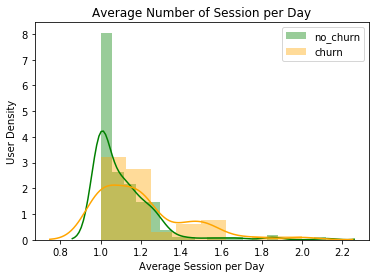

In [61]:
# Sort the dataframe based on churn and not churn
avgsess_nochurn = pd_sessday_churned.loc[pd_sessday_churned['churn_group'] == 0]
avgsess_churn = pd_sessday_churned.loc[pd_sessday_churned['churn_group'] == 1]

# plot the distribution of churn and not churn users
sns.distplot(avgsess_nochurn[['AvgNumSessionPerDay']], label = 'no_churn', color = 'green')
sns.distplot(avgsess_churn[['AvgNumSessionPerDay']], label = 'churn', color = 'orange')
plt.title('Average Number of Session per Day')
plt.xlabel('Average Session per Day')
plt.ylabel('User Density')

plt.legend()
plt.show()

From the distribution plot above, the churned users have lower maximum value and have 'fatter' distribution compared to the non-churned one. 

#### Thumbs Down and Thumbs Up Users

In [62]:
td_churn = df_clean.where(df_clean['page'] == 'Thumbs Down').groupby(["churn_group"]).count().toPandas()
td_churn

,churn_group,count
0,0,2050
1,1,496


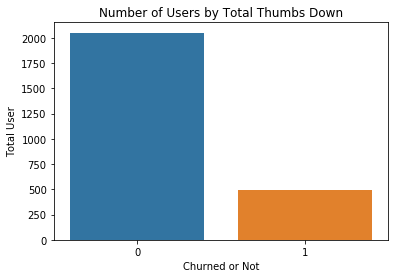

In [63]:
# plot no of users who churned and not by thumbs down page
sns.barplot(x='churn_group', y='count', data = td_churn)
plt.title('Number of Users by Total Thumbs Down')
plt.xlabel('Churned or Not')
plt.ylabel('Total User')
plt.show()

In [64]:
tu_churn = df_clean.where(df_clean['page'] == 'Thumbs Up').groupby(["churn_group"]).count().toPandas()
tu_churn

,churn_group,count
0,0,10692
1,1,1859


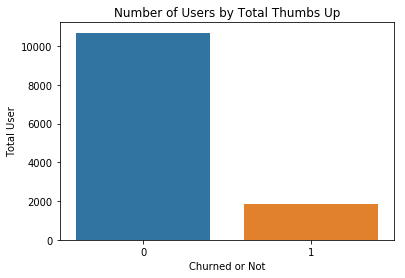

In [65]:
# plot no of users who churned and not by thumbs ip page
sns.barplot(x='churn_group', y='count', data = tu_churn)
plt.title('Number of Users by Total Thumbs Up')
plt.xlabel('Churned or Not')
plt.ylabel('Total User')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [66]:
# check the existing df
df_churn.show()

+------+-----------+
|userId|churn_group|
+------+-----------+
|100010|          0|
|200002|          0|
|   125|          1|
|    51|          1|
|   124|          0|
|     7|          0|
|    54|          1|
|    15|          0|
|   155|          0|
|   132|          0|
|   154|          0|
|100014|          1|
|   101|          1|
|    11|          0|
|   138|          0|
|300017|          0|
|    29|          1|
|    69|          0|
|100021|          1|
|    42|          0|
+------+-----------+
only showing top 20 rows



In [67]:
# check the existing df
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_group: long (nullable = true)



### Extracting Features

In [33]:
# new df for model training
df_model = df_churn

####  Feature from Page Column

In [34]:
# selecting all pages except for nextsong and cancellation confirmation  and make it into list
pages = df_clean.select('page').distinct().toPandas()
list_page = pages.page.tolist()

list_page.remove('Cancellation Confirmation')
list_page.remove('NextSong')
list_page

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [35]:
# create a function to extract features from the page columns
def page_feature(df, page_name):
    page_df = df.where(df.page == page_name).groupBy(['userId']).\
    agg(F.count(F.col('page')).alias('Count' + page_name.replace(' ', ''))).drop('page')
    return page_df

In [36]:
# loop through the name of pages and use the function
# join the new df with the df where pages is extracted
for feature in list_page:
    page_df = page_feature(df_clean, feature)
    df_model = df_model.join(page_df, ['userId'], 'left').fillna(0)

In [37]:
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0)

####  Feature from Gender Column

In [38]:
# selecting the gender column
gender_df = df_clean.select('userId', 'gender').distinct()
# converting the gender into integer type with lambda function
gender_categories = F.udf(lambda gender: 0 if gender == 'M' else 1, IntegerType())
# adding gender categories as a new column
gender_df = gender_df.withColumn('gender', gender_categories(F.col('gender')))
# joining gender column to the model colum
df_model = df_model.join(gender_df, ['userId'])

In [74]:
# checking the new gender column
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1)

####  Feature from Level Column - Paid or Free Users?

In [39]:
# selecting the level column
level_df = df_clean.select('userId', 'level').groupBy('userId').agg(F.max(F.col('level')).alias('isPaid'))
# converting the level into integer type with lambda funciton
level_category = F.udf(lambda level: 0 if level == 'free' else 1, IntegerType())
# adding level category as a new column
level_df = level_df.withColumn('isPaid', level_category(F.col('isPaid')))
# joining level column to the model colum
df_model = df_model.join(level_df, ['userId'])

In [76]:
# checking the new ispaid column
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0)

#### Feature From Page Column - Total Number of Song Played by User

In [40]:
# selecting user id and page and filter it only on the nextsong and aggregate it to find the count
song_df = df_clean.select('userId', 'page').where(df_clean['page'] == 'NextSong').groupby(['userId']).agg(F.count(F.col('page')).alias('countSong'))

# joining song df to the model df
df_model = df_model.join(song_df, ['userId'])                                                                                                      

In [78]:
# checking the count song column
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275)

#### Feature From IteminSession Column - Average Number of Item in 1 Session

In [41]:
# selectng user session id and item in session
avgItemSession = df_clean.select('userId', 'sessionId', 'ItemInSession')
# group by user and session and find the number of item per session
avgItemSession = avgItemSession.groupBy('userId', 'sessionId').agg(F.max(F.col('itemInSession')).alias('numItem'))
# find the average
avgItemSession = avgItemSession.groupBy('userId').agg(F.avg(F.col('numItem')).alias('avgNumItemSession'))

# joining the avg item session table to model df
df_model = df_model.join(avgItemSession, ['userId'])

In [80]:
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275, avgNumItemSession=54.42857142857143)

#### Feature From SessionId Column - Average Number of Session per Day

In [42]:
# convert timestamp(ts) to day format
sessDay_df =  df_clean.withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of session per day group by user id and the day 
sessDay_df = sessDay_df.groupBy(['userId', 'ts']).agg(F.countDistinct(F.col('sessionId')).alias('numSession'))
# group by again by users and get the avg of num of session per day for the user
sessDay_df = sessDay_df.groupBy('userId').agg(F.avg(F.col('numSession')).alias('AvgNumSessionPerDay'))
# join the table with the df churn table and convert to Pandas
df_model = df_model.join(sessDay_df, ['userId'])

In [82]:
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275, avgNumItemSession=54.42857142857143, AvgNumSessionPerDay=1.0)

#### Feature From Page NextSong Column - Average Number of Song Played per Day

In [43]:
# filter to the next song action page only
# convert timestamp(ts) to day format
avgSong_day =  df_clean.where('page == "NextSong"').withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of page per day group by user id and the day 
avgSong_day = avgSong_day.groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('numSong'))
# group by again by users and get the avg of num of page next song per day for the user
avgSong_day = avgSong_day.groupBy('userId').agg(F.avg(F.col('numSong')).alias('AvgNumSongPerDay'))
# join the table with the df churn table and convert to Pandas
df_model = df_model.join(avgSong_day, ['userId'])

In [84]:
# check avg song per day
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275, avgNumItemSession=54.42857142857143, AvgNumSessionPerDay=1.0, AvgNumSongPerDay=39.285714285714285)

#### Feature From Length Column - Average Length of Song Played per Day

In [44]:
# convert timestamp(ts) to day format
# length is defined for length of song (in second) played since it occurs only at page nextsong
avgLengthsong_day =  df_clean.withColumn('ts', F.date_trunc('day', F.col('ts')))
# aggregate the number of length per day group by user id and the day 
avgLengthsong_day = avgLengthsong_day.groupBy(['userId', 'ts']).agg(F.sum(F.col('length')).alias('lengthSongPerDay'))
# group by again by users and get the avg of num of length song per day for the user
avgLengthsong_day = avgLengthsong_day.groupBy('userId').agg(F.avg(F.col('lengthSongPerDay')).alias('AvgLengthSongPerDay'))
# join the table with the df churn table and convert to Pandas
df_model = df_model.join(avgLengthsong_day, ['userId'])

In [86]:
# check avg length per day
df_model.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275, avgNumItemSession=54.42857142857143, AvgNumSessionPerDay=1.0, AvgNumSongPerDay=39.285714285714285, AvgLengthSongPerDay=9562.985335714286)

#### Check Features

In [45]:
df_model.count()

225

In [137]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn_group: long (nullable = true)
 |-- CountCancel: long (nullable = true)
 |-- CountSubmitDowngrade: long (nullable = true)
 |-- CountThumbsDown: long (nullable = true)
 |-- CountHome: long (nullable = true)
 |-- CountDowngrade: long (nullable = true)
 |-- CountRollAdvert: long (nullable = true)
 |-- CountLogout: long (nullable = true)
 |-- CountSaveSettings: long (nullable = true)
 |-- CountAbout: long (nullable = true)
 |-- CountSettings: long (nullable = true)
 |-- CountAddtoPlaylist: long (nullable = true)
 |-- CountAddFriend: long (nullable = true)
 |-- CountThumbsUp: long (nullable = true)
 |-- CountHelp: long (nullable = true)
 |-- CountUpgrade: long (nullable = true)
 |-- CountError: long (nullable = true)
 |-- CountSubmitUpgrade: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- isPaid: integer (nullable = true)
 |-- countSong: long (nullable = false)
 |-- avgNumItemSession: double (nullable = true)
 |-- AvgNu

In [89]:
#count null value from each column
for column in df_model.columns:
    print(column, "missing values:", df_model.filter(F.isnull(df_model[column])).count())

userId missing values: 0
churn_group missing values: 0
CountCancel missing values: 0
CountSubmitDowngrade missing values: 0
CountThumbsDown missing values: 0
CountHome missing values: 0
CountDowngrade missing values: 0
CountRollAdvert missing values: 0
CountLogout missing values: 0
CountSaveSettings missing values: 0
CountAbout missing values: 0
CountSettings missing values: 0
CountAddtoPlaylist missing values: 0
CountAddFriend missing values: 0
CountThumbsUp missing values: 0
CountHelp missing values: 0
CountUpgrade missing values: 0
CountError missing values: 0
CountSubmitUpgrade missing values: 0
gender missing values: 0
isPaid missing values: 0
countSong missing values: 0
avgNumItemSession missing values: 0
AvgNumSessionPerDay missing values: 0
AvgNumSongPerDay missing values: 0
AvgLengthSongPerDay missing values: 0


### Vectorize

In [46]:
# create vector assembler
features = df_model.columns

# removing other than the fetures for the list
features.remove('churn_group')
features.remove('userId')
features

['CountCancel',
 'CountSubmitDowngrade',
 'CountThumbsDown',
 'CountHome',
 'CountDowngrade',
 'CountRollAdvert',
 'CountLogout',
 'CountSaveSettings',
 'CountAbout',
 'CountSettings',
 'CountAddtoPlaylist',
 'CountAddFriend',
 'CountThumbsUp',
 'CountHelp',
 'CountUpgrade',
 'CountError',
 'CountSubmitUpgrade',
 'gender',
 'isPaid',
 'countSong',
 'avgNumItemSession',
 'AvgNumSessionPerDay',
 'AvgNumSongPerDay',
 'AvgLengthSongPerDay']

In [47]:
# create the vector assembler and use it to vectorize the feature
assembler = VectorAssembler(inputCols=features, outputCol='vectorizedFeatures')
df_feature_assemble = assembler.transform(df_model)
df_feature_assemble.head()

Row(userId='100010', churn_group=0, CountCancel=0, CountSubmitDowngrade=0, CountThumbsDown=5, CountHome=11, CountDowngrade=0, CountRollAdvert=52, CountLogout=5, CountSaveSettings=0, CountAbout=1, CountSettings=0, CountAddtoPlaylist=7, CountAddFriend=4, CountThumbsUp=17, CountHelp=2, CountUpgrade=2, CountError=0, CountSubmitUpgrade=0, gender=1, isPaid=0, countSong=275, avgNumItemSession=54.42857142857143, AvgNumSessionPerDay=1.0, AvgNumSongPerDay=39.285714285714285, AvgLengthSongPerDay=9562.985335714286, vectorizedFeatures=DenseVector([0.0, 0.0, 5.0, 11.0, 0.0, 52.0, 5.0, 0.0, 1.0, 0.0, 7.0, 4.0, 17.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 275.0, 54.4286, 1.0, 39.2857, 9562.9853]))

### Scale Features

In [48]:
# scale the features 
scaler = Normalizer(inputCol = 'vectorizedFeatures', outputCol = 'scaled_features')
df_scale = scaler.transform(df_feature_assemble)
#df_scale.head()

In [49]:
# the data created which consist of lable and (vectorized and scaled) features will be used for modeling, hence we need to label it 
df_ml_model = df_scale.select(F.col('churn_group').alias('label'), F.col('scaled_features').alias('features'))

In [50]:
df_ml_model.head()

Row(label=0, features=DenseVector([0.0, 0.0, 0.0005, 0.0011, 0.0, 0.0054, 0.0005, 0.0, 0.0001, 0.0, 0.0007, 0.0004, 0.0018, 0.0002, 0.0002, 0.0, 0.0, 0.0001, 0.0, 0.0287, 0.0057, 0.0001, 0.0041, 0.9995]))

In [51]:
df_ml_model.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train and Test Data

In [52]:
# break the dataset into training and testing sets
train, test = df_ml_model.randomSplit([.8, .2], seed=42)

### Random Forest Classifier


In [143]:
# define the model
rf = RandomForestClassifier()

# define the parameter alternatives to be tested
rf_paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees,[5, 10]) \
            .addGrid(rf.maxDepth,[2, 5]) \
            .build()

# define the cross validator
rf_cross_validation = CrossValidator(estimator = rf,
                          estimatorParamMaps = rf_paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds =3)


In [144]:
# train the model
rf_model = rf_cross_validation.fit(train)

In [145]:
# make prediction with the model
rf_pred = rf_model.transform(test)

In [149]:
# calculate the accuracy, ref calculation from spark lecture
accuracy = rf_pred.filter(rf_pred.label == rf_pred.prediction).count() / rf_pred.count() 
print('Random Forest Accuracy:', accuracy)

Random Forest Accuracy: 0.9411764705882353


### Logistic Regression 

In [160]:
# define the model
lr = LogisticRegression()

# define the parameter alternatives to be tested
lr_paramGrid = ParamGridBuilder()\
                .addGrid(lr.regParam, [0.0, 0.1])\
                .addGrid(lr.maxIter, [5, 10])\
                .build()

# define the cross validator
lr_cross_validation = CrossValidator(estimator=lr,
                              estimatorParamMaps=lr_paramGrid,
                              evaluator = MulticlassClassificationEvaluator(metricName = 'f1'),
                              numFolds=3)


In [161]:
# train the model
lr_model = lr_cross_validation.fit(train)

In [162]:
# make prediction with the model
lr_pred = lr_model.transform(test) 

In [164]:
# calculate the accuracy, ref calculation from spark lecture
accuracy_lr = lr_pred.filter(lr_pred.label == lr_pred.prediction).count() / lr_pred.count()
print('Logistic Regression Accuracy:', accuracy_lr)

Logistic Regression Accuracy: 0.9705882352941176


### Gradient Boosted

In [165]:
# define the model
gbt = GBTClassifier()

# define the parameter alternatives to be tested
gbt_paramGrid = ParamGridBuilder()\
                .addGrid(gbt.maxIter, [5, 10])\
                .addGrid(gbt.maxDepth, [2, 5])\
                .build()

# define the cross validator
gbt_cross_validation = CrossValidator(estimator=gbt,
                              estimatorParamMaps=gbt_paramGrid,
                              evaluator = BinaryClassificationEvaluator(),
                              numFolds=3)


In [166]:
# train the model
gbt_model = gbt_cross_validation.fit(train)

In [167]:
# make prediction with the model
gbt_pred = gbt_model.transform(test)

In [169]:
# calculate the accuracy, ref calculation from spark lecture
accuracy_gbt = gbt_pred.filter(gbt_pred.label == gbt_pred.prediction).count() / gbt_pred.count()
print('Gradient Boosted Accuracy:', accuracy_gbt)

Gradient Boosted Accuracy: 1.0


### Conclusion

I used 3 different models as can be seen above:
1. Random Forrest Classifier
2. Logistic Regression
3. Gradient Boosted

From the result above, Gradient Boosted Tree has the highest accuracy compared to random forrest and logistic regression. The main finding will be posted on my [Medium](https://medium.com/@widyapuspitaloka/predicting-churn-on-sparkify-music-streaming-using-spark-181d74849978).


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.